<h1>Bi LSTM </h1>

In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [57]:
path = "../IDMT-Traffic/datasets/df_main_encoded.csv" 
data = pd.read_csv(path)
print(data.head())

   Unnamed: 0  is_background_encoded  date_time_encoded  location_encoded  \
0          18                      0                  0                 0   
1          19                      0                  0                 0   
2          20                      0                  0                 0   
3          21                      0                  0                 0   
4          24                      0                  0                 0   

   speed_kmh  daytime_encoded  weather_encoded  vehicle_encoded  \
0       30.0                1                0                1   
1       30.0                1                0                1   
2       30.0                1                0                1   
3       30.0                1                0                1   
4       30.0                1                0                1   

   source_direction_encoded  microphone_encoded  ...  band_27_dB  band_28_dB  \
0                         1                   0  ...  

<H2>Feature Selection: Filter Methods </h2>

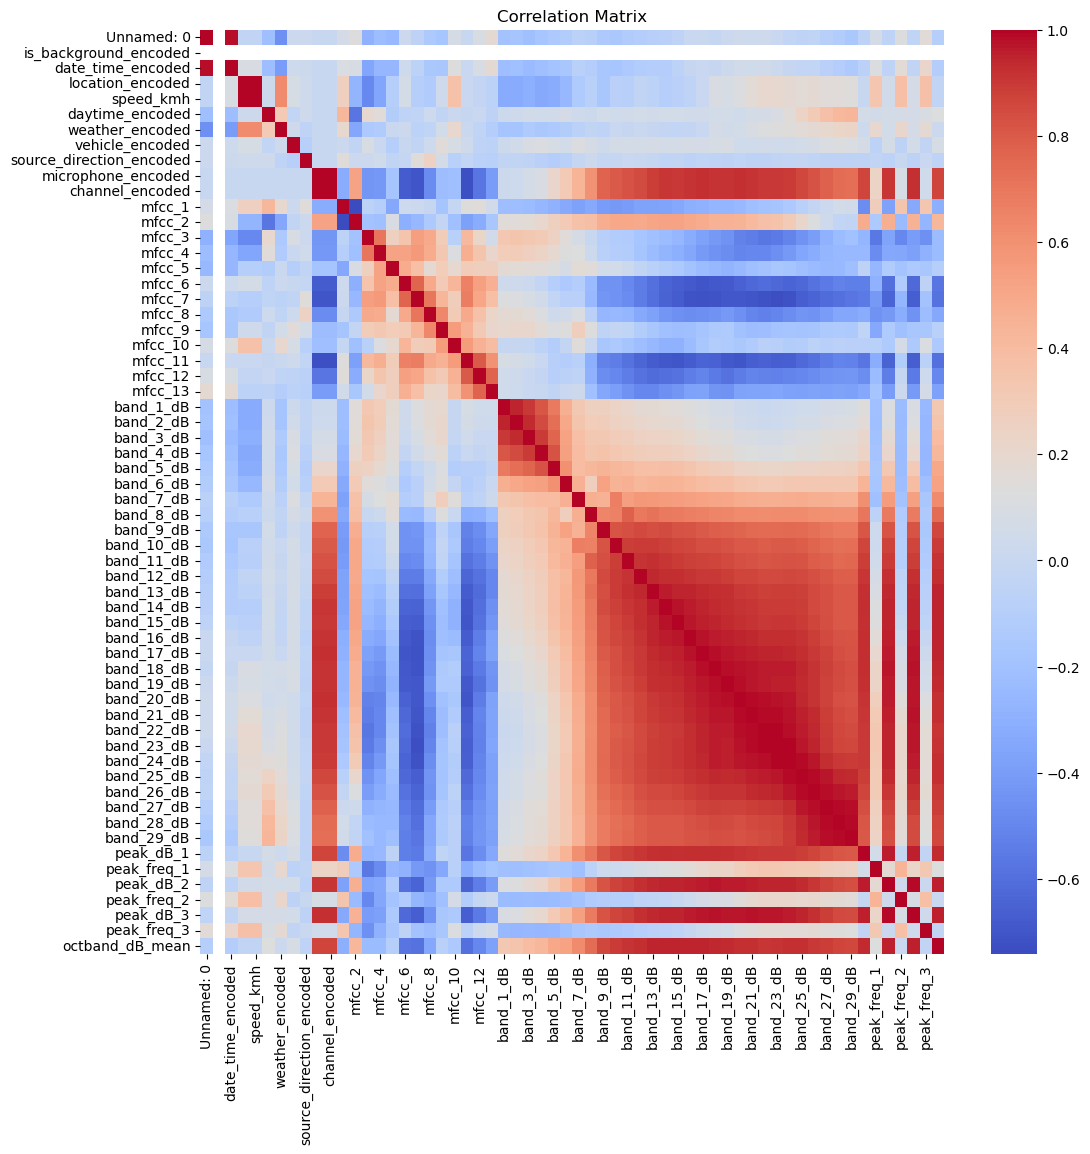

                          Unnamed: 0  is_background_encoded  \
Unnamed: 0                  1.000000                    NaN   
is_background_encoded            NaN                    NaN   
date_time_encoded           0.980824                    NaN   
location_encoded           -0.036224                    NaN   
speed_kmh                  -0.036224                    NaN   
daytime_encoded            -0.212336                    NaN   
weather_encoded            -0.458657                    NaN   
vehicle_encoded             0.014446                    NaN   
source_direction_encoded    0.015998                    NaN   
microphone_encoded         -0.000078                    NaN   
channel_encoded            -0.000078                    NaN   
mfcc_1                      0.073309                    NaN   
mfcc_2                      0.134958                    NaN   
mfcc_3                     -0.293913                    NaN   
mfcc_4                     -0.227426                   

In [5]:
corr_matrix = data.corr()
fig = plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

print(corr_matrix)

In [6]:
#Drop Features that are highly correlated
threshold = 0.9
# Find pairs of features with correlation higher than the threshold
high_corr_pairs = np.where((abs(corr_matrix) > threshold) & (corr_matrix != 1))

# Extract unique pairs
pairs_to_check = [(corr_matrix.index[x], corr_matrix.columns[y]) 
                  for x, y in zip(*high_corr_pairs) if x < y]

# drop 
features_to_drop = set()

# keep 
retained_features = set()

# Ask user which feature to keep -> HIER MÜSSEN WIR DRÜBER REDEN 
for feature1, feature2 in pairs_to_check:
    if feature1 not in features_to_drop and feature2 not in features_to_drop and feature1 not in retained_features and feature2 not in retained_features:
        keep = int(input(f"Welches Feature soll behalten werden? {feature1} oder {feature2} [1,2]")) 
        if keep == 1: 
            features_to_drop.add(feature2)
            retained_features.add(feature1)
        else: 
            features_to_drop.add(feature1)
            retained_features.add(feature2)

In [58]:
features = [col for col in data.columns if col not in features_to_drop]
print(features)
for feature in features:
    if "peak_dB" in feature:
        features.remove(feature)
print(features)



['is_background_encoded', 'date_time_encoded', 'speed_kmh', 'daytime_encoded', 'weather_encoded', 'vehicle_encoded', 'source_direction_encoded', 'microphone_encoded', 'channel_encoded', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'band_1_dB', 'band_3_dB', 'band_4_dB', 'band_5_dB', 'band_6_dB', 'band_7_dB', 'band_8_dB', 'band_9_dB', 'band_10_dB', 'band_11_dB', 'band_13_dB', 'band_17_dB', 'band_19_dB', 'band_21_dB', 'band_23_dB', 'band_25_dB', 'band_27_dB', 'band_29_dB', 'peak_dB_1', 'peak_freq_1', 'peak_freq_2', 'peak_dB_3', 'peak_freq_3']
['is_background_encoded', 'date_time_encoded', 'speed_kmh', 'daytime_encoded', 'weather_encoded', 'vehicle_encoded', 'source_direction_encoded', 'microphone_encoded', 'channel_encoded', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13', 'band_1_dB', 'band_3_dB', 'band_4_dB', 'band_

In [59]:
features = data[features]

In [60]:
# Select target
labels = data["peak_dB_1"].values

In [61]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

In [62]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


In [67]:
original_means = {}
scaled_means = {}
original_stds = {}
scaled_stds = {}

for i in range(len(X_train.columns)):
    print(f"Feature: {X_train.columns[i]}")
    print("Original")
    print(X_train.iloc[:,i].mean())
    print(X_train.iloc[:,i].std())
    print("Scaled")
    print(X_train_scaled[:,i].mean())
    print(X_train_scaled[:,i].std())
    original_means[X_train.columns[i]] = X_train.iloc[:,i].mean()
    scaled_means[X_train.columns[i]] = X_train_scaled[:,i].mean()
    original_stds[X_train.columns[i]] = X_train.iloc[:,i].std()
    scaled_stds[X_train.columns[i]] = X_train_scaled[:,i].std()
    print(30*"-")


print(original_means)

Feature: is_background_encoded
Original
0.0
0.0
Scaled
0.0
0.0
------------------------------
Feature: date_time_encoded
Original
10.684144295302014
4.730958890829844
Scaled
-3.924278252590039e-17
1.0
------------------------------
Feature: speed_kmh
Original
53.45637583892618
12.737237693519353
Scaled
-2.5184924988141136e-16
1.0
------------------------------
Feature: daytime_encoded
Original
0.3868847874720358
0.4870709594841129
Scaled
5.960928991276008e-17
1.0000000000000002
------------------------------
Feature: weather_encoded
Original
0.18819910514541388
0.3908984098716512
Scaled
-3.9739526608506724e-17
1.0
------------------------------
Feature: vehicle_encoded
Original
1.2175615212527964
0.6485113352017905
Scaled
2.9307900873773706e-17
1.0
------------------------------
Feature: source_direction_encoded
Original
0.5102069351230425
0.4999307592577706
Scaled
8.842044670392746e-17
0.9999999999999997
------------------------------
Feature: microphone_encoded
Original
0.49860178970

In [98]:
show_means = []

for key in original_means.keys():
    show_means.append({"Feature": key, "Value": original_means[key], "Type": "Original"})
    show_means.append({"Feature": key, "Value": scaled_means[key], "Type": "Scaled"})

show_means = pd.DataFrame(show_means)

show_stds = []
for key in original_stds.keys():
    show_stds.append({"Feature": key, "Value": original_stds[key], "Type": "Original"})
    show_stds.append({"Feature": key, "Value": scaled_stds[key], "Type": "Scaled"})

show_stds = pd.DataFrame(show_stds)

print(show_means)


                  Feature         Value      Type
0   is_background_encoded  0.000000e+00  Original
1   is_background_encoded  0.000000e+00    Scaled
2       date_time_encoded  1.068414e+01  Original
3       date_time_encoded -3.924278e-17    Scaled
4               speed_kmh  5.345638e+01  Original
..                    ...           ...       ...
81            peak_freq_1  7.401487e-17    Scaled
82            peak_freq_2  9.717223e+02  Original
83            peak_freq_2 -3.477209e-17    Scaled
84            peak_freq_3  1.106820e+03  Original
85            peak_freq_3  9.736184e-17    Scaled

[86 rows x 3 columns]


<h3>Showing the effects of the standardization </h3>

-2.5728859758595073e-16 3.062675641309353e-16


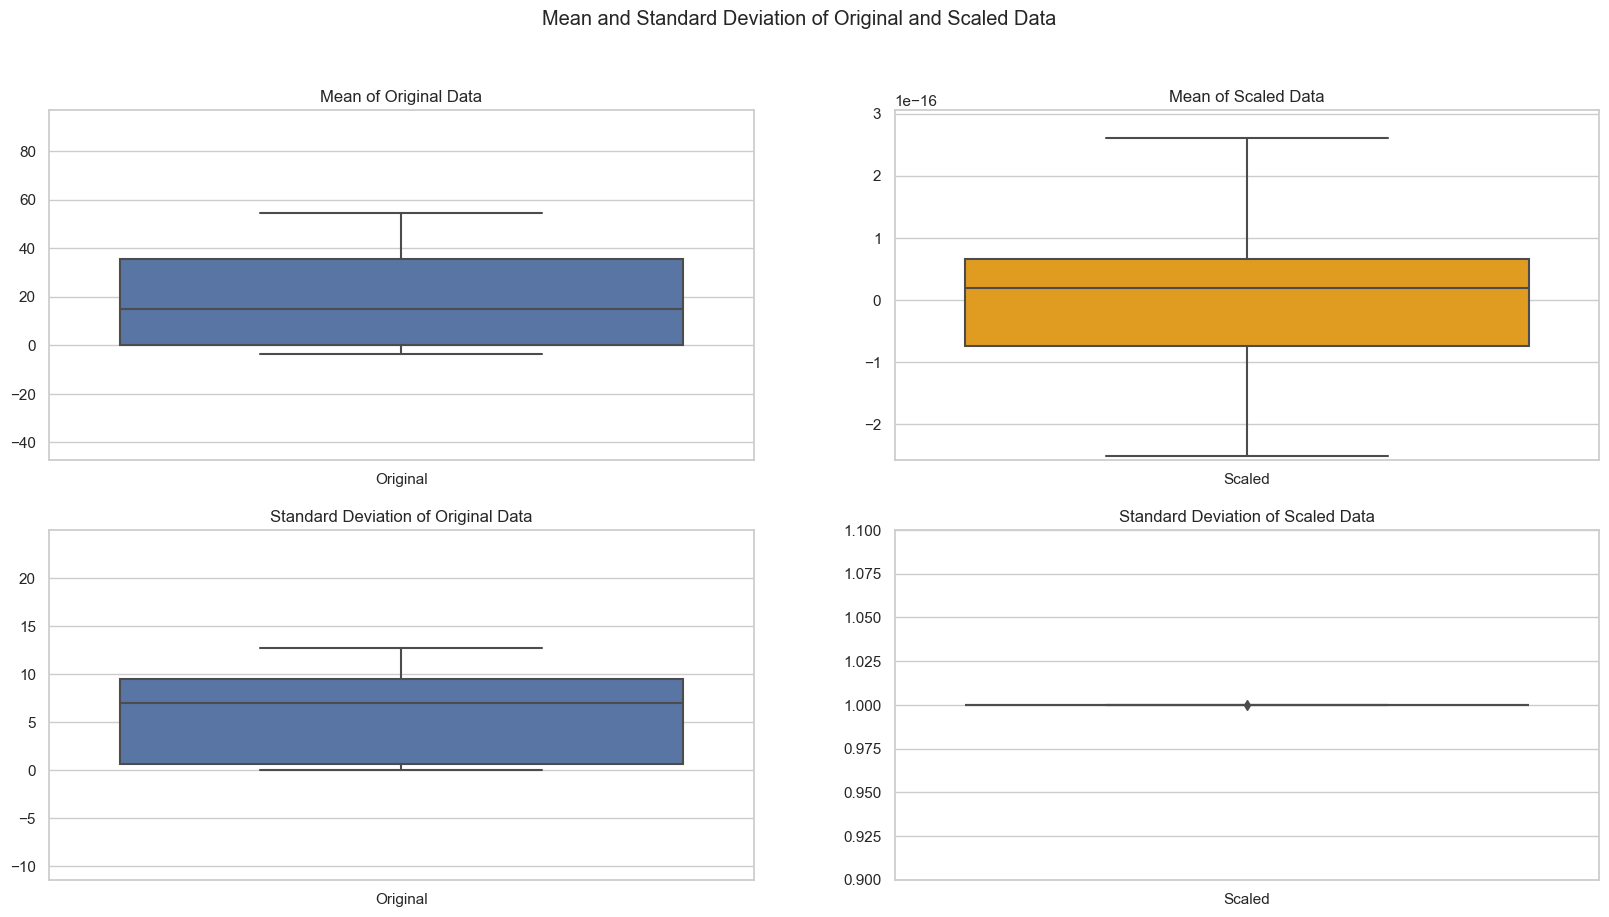

In [127]:
# define dataframes for original/scaled meand/stds
original_data_mean = show_means[show_means["Type"] == "Original"]
scaled_data_mean = show_means[show_means["Type"] == "Scaled"]
original_data_std = show_stds[show_stds["Type"] == "Original"]
scaled_data_std = show_stds[show_stds["Type"] == "Scaled"]

# Get the y range for the boxplots
def get_y_range(data):
    q1 = data["Value"].quantile(0.25)
    q3 = data["Value"].quantile(0.75)
    iqr = q3 - q1
    return (q1 - 1.5 * iqr) * 0.9 , (q3 + 1.5 * iqr) * 1.1

# Define the Plot 
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

# Boxplot for original mean 
sns.boxplot(x="Type", y="Value", data=original_data_mean, ax=ax[0, 0])
ax[0, 0].set_title("Mean of Original Data")
ax[0, 0].set_ylabel("")
ax[0, 0].set_xlabel("")
min_y, max_y = get_y_range(original_data_mean)
ax[0, 0].set_ylim(min_y, max_y)

# Boxplot for scaled mean
sns.boxplot(x="Type", y="Value", data=scaled_data_mean, ax=ax[0, 1], color="orange")
ax[0, 1].set_ylabel("")
ax[0, 1].set_xlabel("")
ax[0, 1].set_title("Mean of Scaled Data")
min_y, max_y = get_y_range(scaled_data_mean)
ax[0, 1].set_ylim(min_y, max_y)

# Boxplot for original std
sns.boxplot(x="Type", y="Value", data=original_data_std, ax=ax[1, 0])
ax[1, 0].set_ylabel("")
ax[1, 0].set_xlabel("")
ax[1, 0].set_title("Standard Deviation of Original Data")
min_y, max_y = get_y_range(original_data_std)
ax[1, 0].set_ylim(min_y, max_y)

# Boxplot for scaled std
sns.boxplot(x="Type", y="Value", data=scaled_data_std, ax=ax[1, 1], color="orange")
ax[1, 1].set_ylabel("")
ax[1, 1].set_xlabel("")
ax[1, 1].set_title("Standard Deviation of Scaled Data")
min_y, max_y = get_y_range(scaled_data_std)
ax[1, 1].set_ylim(min_y, max_y)

fig.suptitle("Mean and Standard Deviation of Original and Scaled Data")
plt.show()


In [120]:
X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(1)
y_train_tensor = torch.FloatTensor(y_train_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

5.26548727562714e-16
